# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

![img](https://raw.githubusercontent.com/qiaochen/TransImgClassifier4Flowers/master/assets/Flowers.png)

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
import torchvision
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from collections import OrderedDict
from PIL import Image
import numpy as np
from matplotlib import image as matimg
from matplotlib import pyplot as plt
import json
import os
torch.manual_seed(999)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = '../../flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
trs_means = (0.485, 0.456, 0.406)
trs_stds = (0.229, 0.224, 0.225)
train_transforms = transforms.Compose([
                   transforms.RandomRotation(30),
                   transforms.RandomResizedCrop(224),
                   transforms.RandomHorizontalFlip(),
                   transforms.ToTensor(),
                   transforms.Normalize(trs_means, trs_stds)])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(trs_means, trs_stds)])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
dev_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
image_datasets = {'train': train_data, 'valid': dev_data, 'test': test_data}

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
devloader = torch.utils.data.DataLoader(dev_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': trainloader, 'valid':devloader, 'test':testloader}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [5]:
# TODO: Build and train your network
model = models.densenet201(pretrained=True)
input_dim = model.classifier.in_features
hidden_dim = 500
output_dim = 102
for param in model.parameters():
    param.requires_grad = False

def get_classifier(
            input_dim = 1920, 
            hidden_dim = 500,
            output_dim = 102,
            ):
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_dim, hidden_dim)),
                          ('bn1', nn.BatchNorm1d(hidden_dim)),
                          ('dropout1', nn.Dropout(0.2)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_dim, output_dim)),
                          ('dropout2', nn.Dropout(0.1)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    return classifier
classifier = get_classifier(input_dim, hidden_dim, output_dim)
model.classifier = classifier

/home/chen/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [6]:
def validate(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    count = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model.forward(images)
        test_loss += criterion(outputs, labels)
        count += images.size()[0]
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).sum()
        model.train()
    return test_loss/count, accuracy/count

In [7]:
def train(model, 
          dataloaders,
          lr=5e-4, 
          lr_decay=.995, 
          feedback_interval=10, 
          n_epoches=1000,
          tolerance_thred=3,
          tmp_path="./best_model.pth"):
    tolerance = tolerance_thred
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    model.to(device)
    dev_losses, lowest_dev_loss = [], float('inf')
    dev_acces = []
    losses = []
    for i_epoch in range(1, n_epoches+1):
        model.train()
        for ii, (inputs, labels) in enumerate(dataloaders['train']):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            print("Epoch: {}, iter: {}, train_loss {}".format(i_epoch, ii+1, loss))
            if (ii+1) % feedback_interval == 0:
                dev_loss, dev_acc = validate(model, dataloaders['valid'], nn.NLLLoss(size_average=False))
                dev_losses.append(dev_loss)
                dev_acces.append(dev_acc)
                if dev_loss < lowest_dev_loss:
                    lowest_dev_loss = dev_loss
                    tolerance = tolerance_thred
                    torch.save(model.classifier.state_dict(), tmp_path)
                    print("Best model saved..")
                else:
                    if tolerance == 0:
                        break
                    model.classifier.load_state_dict(torch.load(tmp_path))
                    optimizer = optim.Adam(model.classifier.parameters(), lr=lr*lr_decay)
                    model.train()
                    tolerance -= 1
                    print("Recoverred from last best model.")
                print("Epoch: {}, iter: {}, dev_acc: {}, dev_loss {}".format(
                    i_epoch, ii+1, dev_acc, dev_loss))
                    
                    
        if tolerance == 0: 
            print("Performance halts, early-stop training.")
            break
    return model, dev_losses, dev_acces, lowest_dev_loss, losses

model, dev_losses, dev_acces, lowest_dev_loss, train_losses = train(model, dataloaders)

Epoch: 1, iter: 1, train_loss 4.638203144073486
Epoch: 1, iter: 2, train_loss 4.5930023193359375
Epoch: 1, iter: 3, train_loss 4.538491725921631
Epoch: 1, iter: 4, train_loss 4.572889804840088
Epoch: 1, iter: 5, train_loss 4.468624114990234
Epoch: 1, iter: 6, train_loss 4.470580101013184
Epoch: 1, iter: 7, train_loss 4.440011024475098
Epoch: 1, iter: 8, train_loss 4.317224025726318
Epoch: 1, iter: 9, train_loss 4.38853645324707
Epoch: 1, iter: 10, train_loss 4.331295490264893
Best model saved..
Epoch: 1, iter: 10, dev_acc: 0.13569682836532593, dev_loss 4.4317307472229
Epoch: 1, iter: 11, train_loss 4.309022426605225
Epoch: 1, iter: 12, train_loss 4.249337673187256
Epoch: 1, iter: 13, train_loss 4.198237419128418
Epoch: 1, iter: 14, train_loss 4.1540679931640625
Epoch: 1, iter: 15, train_loss 4.057779312133789
Epoch: 1, iter: 16, train_loss 4.07141637802124
Epoch: 1, iter: 17, train_loss 3.9622907638549805
Epoch: 1, iter: 18, train_loss 3.9433279037475586
Epoch: 1, iter: 19, train_loss 

Epoch: 2, iter: 39, train_loss 2.0373454093933105
Epoch: 2, iter: 40, train_loss 1.8566854000091553
Best model saved..
Epoch: 2, iter: 40, dev_acc: 0.8178483843803406, dev_loss 1.4737846851348877
Epoch: 2, iter: 41, train_loss 2.026397228240967
Epoch: 2, iter: 42, train_loss 1.787966012954712
Epoch: 2, iter: 43, train_loss 1.9049134254455566
Epoch: 2, iter: 44, train_loss 1.9575084447860718
Epoch: 2, iter: 45, train_loss 1.9987304210662842
Epoch: 2, iter: 46, train_loss 2.053130626678467
Epoch: 2, iter: 47, train_loss 2.095475912094116
Epoch: 2, iter: 48, train_loss 1.5391753911972046
Epoch: 2, iter: 49, train_loss 2.045940399169922
Epoch: 2, iter: 50, train_loss 2.013578176498413
Best model saved..
Epoch: 2, iter: 50, dev_acc: 0.8264058828353882, dev_loss 1.3862531185150146
Epoch: 2, iter: 51, train_loss 1.7503265142440796
Epoch: 2, iter: 52, train_loss 2.0372202396392822
Epoch: 2, iter: 53, train_loss 1.668317198753357
Epoch: 2, iter: 54, train_loss 2.090564489364624
Epoch: 2, iter: 

Epoch: 3, iter: 74, train_loss 1.0168427228927612
Epoch: 3, iter: 75, train_loss 1.110093593597412
Epoch: 3, iter: 76, train_loss 1.0650290250778198
Epoch: 3, iter: 77, train_loss 1.1693158149719238
Epoch: 3, iter: 78, train_loss 1.1119672060012817
Epoch: 3, iter: 79, train_loss 0.9403365850448608
Epoch: 3, iter: 80, train_loss 0.946736216545105
Best model saved..
Epoch: 3, iter: 80, dev_acc: 0.9400978088378906, dev_loss 0.6252947449684143
Epoch: 3, iter: 81, train_loss 1.2449889183044434
Epoch: 3, iter: 82, train_loss 1.4032694101333618
Epoch: 3, iter: 83, train_loss 1.0999104976654053
Epoch: 3, iter: 84, train_loss 1.5295542478561401
Epoch: 3, iter: 85, train_loss 0.9622619152069092
Epoch: 3, iter: 86, train_loss 1.124216914176941
Epoch: 3, iter: 87, train_loss 1.129360318183899
Epoch: 3, iter: 88, train_loss 1.0975984334945679
Epoch: 3, iter: 89, train_loss 1.1511296033859253
Epoch: 3, iter: 90, train_loss 1.3508458137512207
Best model saved..
Epoch: 3, iter: 90, dev_acc: 0.94132030

Epoch: 5, iter: 8, train_loss 1.03255033493042
Epoch: 5, iter: 9, train_loss 0.9795730710029602
Epoch: 5, iter: 10, train_loss 0.7516562938690186
Best model saved..
Epoch: 5, iter: 10, dev_acc: 0.9621027112007141, dev_loss 0.371736615896225
Epoch: 5, iter: 11, train_loss 0.7536402940750122
Epoch: 5, iter: 12, train_loss 0.6639977097511292
Epoch: 5, iter: 13, train_loss 0.7544497847557068
Epoch: 5, iter: 14, train_loss 0.8840718269348145
Epoch: 5, iter: 15, train_loss 1.0201092958450317
Epoch: 5, iter: 16, train_loss 0.881367564201355
Epoch: 5, iter: 17, train_loss 0.7487660050392151
Epoch: 5, iter: 18, train_loss 0.6698435544967651
Epoch: 5, iter: 19, train_loss 1.0326989889144897
Epoch: 5, iter: 20, train_loss 0.6200182437896729
Best model saved..
Epoch: 5, iter: 20, dev_acc: 0.9669926762580872, dev_loss 0.35860899090766907
Epoch: 5, iter: 21, train_loss 0.9286913871765137
Epoch: 5, iter: 22, train_loss 0.8170766234397888
Epoch: 5, iter: 23, train_loss 0.9247139096260071
Epoch: 5, ite

Epoch: 6, iter: 42, train_loss 0.7788293957710266
Epoch: 6, iter: 43, train_loss 0.5936892628669739
Epoch: 6, iter: 44, train_loss 0.7425444722175598
Epoch: 6, iter: 45, train_loss 0.9994239807128906
Epoch: 6, iter: 46, train_loss 0.7487728595733643
Epoch: 6, iter: 47, train_loss 0.854266345500946
Epoch: 6, iter: 48, train_loss 0.9186262488365173
Epoch: 6, iter: 49, train_loss 0.844753086566925
Epoch: 6, iter: 50, train_loss 0.6881826519966125
Best model saved..
Epoch: 6, iter: 50, dev_acc: 0.9572126865386963, dev_loss 0.2798205316066742
Epoch: 6, iter: 51, train_loss 0.7650350332260132
Epoch: 6, iter: 52, train_loss 0.8546056151390076
Epoch: 6, iter: 53, train_loss 1.1062246561050415
Epoch: 6, iter: 54, train_loss 0.744040846824646
Epoch: 6, iter: 55, train_loss 0.8623412251472473
Epoch: 6, iter: 56, train_loss 0.7581592202186584
Epoch: 6, iter: 57, train_loss 0.9735170006752014
Epoch: 6, iter: 58, train_loss 0.8652313947677612
Epoch: 6, iter: 59, train_loss 0.6818258762359619
Epoch: 

Epoch: 7, iter: 78, train_loss 0.9286518692970276
Epoch: 7, iter: 79, train_loss 0.6869990825653076
Epoch: 7, iter: 80, train_loss 0.5522410869598389
Best model saved..
Epoch: 7, iter: 80, dev_acc: 0.955990195274353, dev_loss 0.23274767398834229
Epoch: 7, iter: 81, train_loss 0.5580401420593262
Epoch: 7, iter: 82, train_loss 0.770810067653656
Epoch: 7, iter: 83, train_loss 0.5054407119750977
Epoch: 7, iter: 84, train_loss 0.536384642124176
Epoch: 7, iter: 85, train_loss 0.8899099230766296
Epoch: 7, iter: 86, train_loss 0.8686865568161011
Epoch: 7, iter: 87, train_loss 0.743291974067688
Epoch: 7, iter: 88, train_loss 0.4888550043106079
Epoch: 7, iter: 89, train_loss 0.8611809611320496
Epoch: 7, iter: 90, train_loss 0.7009798288345337
Best model saved..
Epoch: 7, iter: 90, dev_acc: 0.9621027112007141, dev_loss 0.22372111678123474
Epoch: 7, iter: 91, train_loss 0.465707391500473
Epoch: 7, iter: 92, train_loss 0.6453678607940674
Epoch: 7, iter: 93, train_loss 0.7051166892051697
Epoch: 7, i

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set
test_loss, accuracy = validate(model, dataloaders['test'], nn.NLLLoss(size_average=False))
print("Test accuracy: {}, test loss: {}".format(accuracy, test_loss))

Test accuracy: 0.949938952922821, test loss: 0.23964929580688477


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [22]:
# TODO: Save the checkpoint 
final_model_path = "./final_model.pth"
torch.save({"class2idx":image_datasets['train'].class_to_idx,
            "output_dim": output_dim,
            "hidden_dim": hidden_dim,
            "pre_model_name":"densenet201",
            "cat_to_name":cat_to_name,
            "model_state_dict":model.state_dict()}, final_model_path)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [24]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load(path, device_name='cpu'):
    device = torch.device(device_name)
    if device_name == "cpu":
        loaded = torch.load(path, map_location=device_name)
    else:
        loaded = torch.load(path)
    if loaded['pre_model_name'] == 'densenet201':
        model = models.densenet201(pretrained=False)
    else:
        print('This mode is not supported, please specify "densenet201"')
        
    for param in model.parameters():
        param.requires_grad = False   
    
    model.classifier = get_classifier(model.classifier.in_features,
                                     loaded['hidden_dim'],
                                     loaded['output_dim'])
    class2idx = loaded['class2idx']
    cat_to_name = loaded['cat_to_name']
    model.load_state_dict(loaded['model_state_dict'])
    return model.to(device), class2idx, cat_to_name


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [55]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    width, height = image.size   # Get dimensions
    
    # resize
    if width < height:
        new_height = int(np.floor(256.0 * height / width ))
        new_weight = 256
    else:
        new_width = int(np.floor(256.0 * width / height))
        new_height = 256
    image.resize((new_width, new_height), Image.ANTIALIAS)
    
    # center crop
    width, height = new_width, new_height
    new_width, new_height = 224, 224
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    
    image = image.crop((left, top, right, bottom))
    np_image = np.array(image)
    
    # Normalize
    np_image = np.divide(np_image,255)
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_image = np.divide(np_image - means, stds)
    return np.transpose(np_image, (2,0,1))


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, class2idx, topk=5, device_name='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    im = Image.open(image_path)
    image = process_image(im)
    model.eval()
    idx2class = {v:k for k,v in class2idx.items()}
    with torch.no_grad():
        log_probs = model(torch.from_numpy(image).unsqueeze(0).float().to(device_name))
        probs = torch.exp(log_probs)
        preds, indices = probs.squeeze().topk(topk)
    return preds.cpu().numpy(), [idx2class[idx] for idx in indices.cpu().numpy()], image

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

![img](https://raw.githubusercontent.com/qiaochen/TransImgClassifier4Flowers/master/assets/inference_example.png)

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

/home/chen/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Text(0.5,0,'Probabilities')

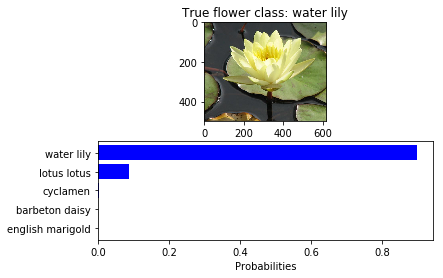

In [53]:
# TODO: Display an image along with the top 5 classes
final_model_path = "./final_model.pth"
device_name = "cpu" # or "cuda"
loaded_model, class2idx, cat_to_name = load(final_model_path, device_name=device_name)

# randomly sample an image from the test set 
index = np.random.choice(os.listdir(test_dir))
class_true = [k for k, v in class2idx.items() if v == int(index)][0]
class_true = cat_to_name[class_true]
figure_dir = os.path.join(test_dir, index)
img_path = os.path.join(figure_dir, np.random.choice(os.listdir(figure_dir)))

# predict
probs, classes, image = predict(img_path, loaded_model, device_name = device_name, class2idx=class2idx, topk=5)

class_names = [cat_to_name[clz] for clz in classes]

mat_image = matimg.imread(img_path)
fig, ax = plt.subplots(2, 1)
ax[0].set_title("True flower class: {}".format(class_true))
ax[0].imshow(mat_image)
y_pos = np.arange(len(classes))
ax[1].barh(y_pos,probs, align='center', color='blue')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(class_names)
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_xlabel('Probabilities')

recoverred image:


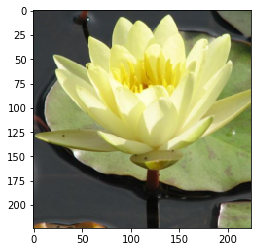

In [54]:
print("recoverred image:")
imshow(image)